## Introduction  
The goal of this portion of the project is to predict a movie's revenue using its other characteristics.

## Data Preprocessing for Model Input  

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from scipy.special import inv_boxcox

In [37]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb

In [71]:
df = pd.read_csv("movies_post_eda.csv")

#### Select Predictor Variables

In [9]:
df.columns

Index(['index', 'budget', 'id', 'original_language', 'original_title',
       'overview', 'popularity', 'release_date', 'runtime', 'tagline', 'title',
       'vote_average', 'vote_count', 'genres', 'keywords',
       'production_companies', 'production_countries', 'year', 'month', 'date',
       'spoken_languages', 'cast', 'director', 'exec_prod', 'screenplay',
       'composer', 'budget_range', 'runtime_range', 'century', 'genre',
       'production_company', 'production_country', 'spoken_language',
       'overview_length', 'num_spoken_languages', 'top30cast_yn',
       'top100directors_yn', 'top100exec_prod_yn', 'top100screenplays_yn',
       'top100composers_yn', 'top100prod_comp_yn', 'top15prod_country_yn',
       'log_revenue', 'revenue'],
      dtype='object')

In [10]:
# choose relevant columns
df_model = df[['revenue','budget','original_language','runtime','genres','year','month','date',
               'overview_length', 'num_spoken_languages', 'top30cast_yn','top100directors_yn', 
               'top100screenplays_yn', 'top100composers_yn','top100prod_comp_yn', 'top15prod_country_yn']]

#### Normalize our response variable 'revenue':

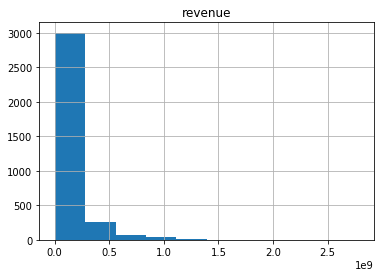

In [4]:
plt.hist(df_model['revenue'])
plt.title('revenue')
plt.grid()
plt.show()

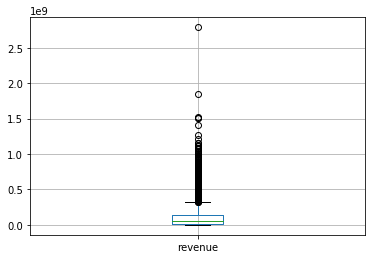

In [5]:
df_model.boxplot(column = 'revenue')

Revenue is extremely right-skewed, with many high outliers.  

Before we can perform regression on our dataset, we need to normalize our response variable.  
  
We first try out a log transform:

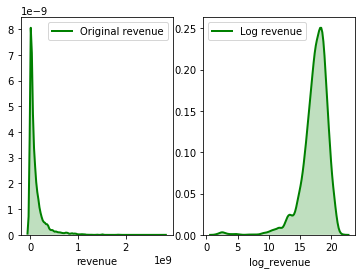

In [6]:
df_model['log_revenue'] = df_model['revenue'].apply(lambda x: math.log(x))

fig, ax = plt.subplots(1, 2)
  
sns.distplot(df_model['revenue'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Original revenue", color ="green", ax = ax[0])
  
sns.distplot(df_model['log_revenue'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Log revenue", color ="green", ax = ax[1])

The log transform was unsuccessful in normalizing the revenue distribution.

Now we'll try a box cox transform:

lambda = 0.20366614517723822


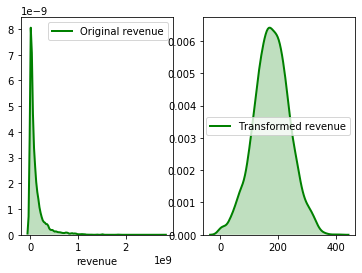

In [89]:
# transform training data & save lambda value
fitted_revenue, fitted_lambda = stats.boxcox(df_model['revenue'])
  

fig, ax = plt.subplots(1, 2)
  
sns.distplot(df['revenue'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Original revenue", color ="green", ax = ax[0])
  
sns.distplot(fitted_revenue, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Transformed revenue", color ="green", ax = ax[1])


print('lambda = %s' %fitted_lambda)

The box cox transform was successful in normalizing revenue.  
We have a lambda of 0.204, meaning that transformed revenue is equal to (original revenue)$^{0.204}$.

Now we drop the revenue column of our model dataframe and replace it with the fitted revenue values:

In [8]:
df_model.drop(columns = 'revenue', inplace = True)
df_model['revenue'] = fitted_revenue
df_model.revenue.head()

0    406.965938
1    326.646699
2    320.804617
3    334.940052
4    253.779758
Name: revenue, dtype: float64

#### Impute Missing Data

Recall from the eda file that we had missing values in the form of runtime = 0 and budget = 0.  
We will impute those values with the medians of each variable:

In [11]:
print(len(df_model[df_model['budget'] == 0]))
print(len(df_model[df_model['runtime'] == 0]))

147
1


In [12]:
df_model['budget'] = df_model['budget'].apply(lambda x: df_model['budget'].median() if x == 0 else x)
df_model['runtime'] = df_model['runtime'].apply(lambda x: df_model['runtime'].median() if x == 0 else x)

C:\Users\jamie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\jamie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
print(len(df_model[df_model['budget'] == 0]))
print(len(df_model[df_model['runtime'] == 0]))

0
0


#### Convert 'genres' column into dummy columns  
Take a look at our 'genres' values

In [14]:
df_model.genres[0]

"['Action', 'Adventure', 'Fantasy', 'Science Fiction']"

In [15]:
genres_ser = df_model['genres'].apply(eval)

In [16]:
unique_genres = pd.Series([x for _list in genres_ser for x in _list]).value_counts()

In [17]:
def boolean_df(item_lists, unique_items):
    
    bool_dict = {}

    for i, item in enumerate(unique_items):
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
        
    return pd.DataFrame(bool_dict)

In [18]:
genres_bool = boolean_df(df_model['genres'], unique_genres.keys())
genres_bool

,Drama,Comedy,Thriller,Action,Adventure,Romance,Crime,Science Fiction,Family,Fantasy,Horror,Mystery,Animation,History,War,Music,Western,Documentary,Foreign
0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3372,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3373,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
3374,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Now we can merge the model dataframe with our genres boolean dataframe and drop the 'genres' column in our model dataframe:

In [19]:
df_model = pd.merge(df_model, genres_bool, left_index = True, right_index = True)
df_model.drop(columns = 'genres', inplace=True)

#### Multiple Linear Regression using OLS regression

In [20]:
# get dummy data
df_dum = pd.get_dummies(df_model)

In [21]:
# train test split
X = df_dum.drop('revenue', axis = 1)
y = df_dum.revenue.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 88)

In [22]:
# multiple linear regression
X_sm = X = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()

C:\Users\jamie\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     72.86
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:51:36   Log-Likelihood:                -17301.
No. Observations:                3376   AIC:                         3.472e+04
Df Residuals:                    3316   BIC:                         3.509e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -382.5448    120.477     -3.175      0.002    -618.761    -146.328
budget                4.409e-07   2.55e-08     17.257      0.000    3.91e-07    4.91e-07
runtime                  0.4555      0.045     10.129      0.000       0.367       0.544
year                     0.2330      0.061      3.790      0.000       0.112       0.354
month                    0.2215      0.217      1.020      0.308      -0.204       0.647
date                     0.0965      0.084      1.150      0.250      -0.068       0.261
overview_length          0.0091      0.005      1.932      0.053      -0.000       0.018
num_spoken_languages     2.6188      0.777      3.368      0.001       1.094       4.143
top30cast_yn           -12.9063      1.897     -6.805      0.000     -16.625      -9.188
top100directors_yn      16.4525      3.005      5.475      0.000      10.561      22.344
top100screenplays_yn    21.2112      3.370      6.295      0.000      14.604      27.818
top100composers_yn      20.3564      1.906     10.681      0.000      16.620      24.093
top100prod_comp_yn      23.0470      1.632     14.119      0.000      19.846      26.247
top15prod_country_yn    12.8116      2.348      5.457      0.000       8.209      17.414
Drama                  -13.0656      1.833     -7.126      0.000     -16.660      -9.471
Comedy                   1.1227      1.897      0.592      0.554      -2.596       4.841
Thriller                 1.6945      1.976      0.858      0.391      -2.180       5.569
Action                  -1.3605      2.025     -0.672      0.502      -5.331       2.610
Adventure                3.7388      2.188      1.709      0.088      -0.552       8.029
Romance                  6.1180      2.036      3.005      0.003       2.127      10.109
Crime                   -1.9510      2.175     -0.897      0.370      -6.215       2.313
Science Fiction         -4.8527      2.331     -2.082      0.037      -9.422      -0.283
Family                  10.9575      3.018      3.630      0.000       5.039      16.876
Fantasy                 -0.5166      2.550     -0.203      0.839      -5.517       4.484
Horror                   9.2453      2.738      3.376      0.001       3.877      14.614
Mystery                 -0.7858      2.782     -0.283      0.778      -6.240       4.668
Animation                4.8865      4.072      1.200      0.230      -3.097      12.870
History                -10.2523      3.877     -2.645      0.008     -17.853      -2.651
War                     -4.8021      4.182     -1.148      0.251     -13.002       3.398
Music                    2.1378      3.922      0.545      0.586      -5.552       9.828
Western                -22.0196      5.495     -4.007      0.000     -32.793     -11.246
Documentary            -22.4481      6.368     -3.525    

We have a pretty decent R-squared of 0.565, meaning our independent variables account for 56.5% of the variability in movie revenue.  
We will take a significance level of 0.05, so we consider any variable with p-value less than 0.05 to be statistically significant.  
We can say that budget, runtime, number of spoken languages, genre, and whether or not the movie included some of the top cast and crew members, and top production companies and production countries all have a significant impact on movie revenue.  

## Baseline Models

- Multiple Linear Regression:

In [43]:
df.revenue.describe()

count    3376.000000
mean      178.012955
std        61.661760
min         1.904562
25%       137.869129
50%       177.961765
75%       219.104383
max       406.965938
Name: revenue, dtype: float64

In [47]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

np.mean(cross_val_score(model_lr, X_train, y_train, scoring = 'neg_mean_absolute_error',  cv = 3))

-31.734370993228463

- Lasso Regression:

In [48]:
model_l = Lasso()
model_l.fit(X_train, y_train)

np.mean(cross_val_score(model_l, X_train, y_train, scoring = 'neg_mean_absolute_error',  cv = 3))

-32.545256588171895

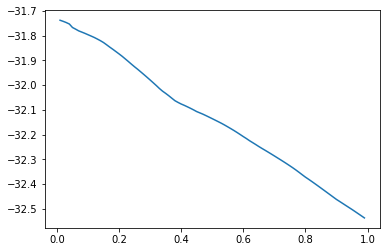

0.01


-31.738014651420674

In [51]:
# let's find the best alpha to minimize error
alpha = []
error = []
for i in range(1,100):
    alpha.append(i/100)
    lasso = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lasso, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3)))
plt.plot(alpha, error)
plt.show()

print(alpha[np.argmax(error)])  # best alpha to minimize error

# lasso with optimized alpha
model_l = Lasso(alpha = alpha[np.argmax(error)])
model_l.fit(X_train, y_train)
np.mean(cross_val_score(model_l, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

- Elastic Net Regression:

C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1246988.6056181733, tolerance: 582.6378479656056
  positive)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jamie\

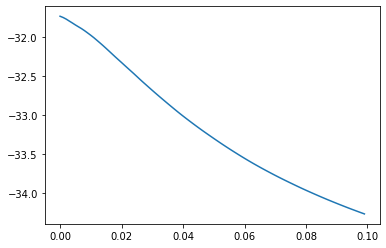

0.0


C:\Users\jamie\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1911533.2980514453, tolerance: 874.9214602061223
  positive)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_des

-31.734370993357288

In [30]:
# let's find the best alpha to minimize error
alpha = []
error = []
for i in range(0,100):
    alpha.append(i/1000)
    en = ElasticNet(alpha=(i/100))
    error.append(np.mean(cross_val_score(en, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3)))
plt.plot(alpha, error)
plt.show()
print(alpha[np.argmax(error)])

# elastic net with optimized alpha
model_en = ElasticNet(alpha = alpha[np.argmax(error)])
model_en.fit(X_train, y_train)
np.mean(cross_val_score(model_en, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

- Kernel Ridge Regression:  
I attempted the kernel ridge regression on the train data. However, I got the singular matrix error when running the code. Thus, I will omit the kernel ridge regression code and error.

- Support Vector Regression:

In [31]:
model_svr = SVR()
model_svr.fit(X_train, y_train)
np.mean(cross_val_score(model_svr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

-48.44683331868757

- Gradient Boosting Regression:

In [32]:
model_gb = GradientBoostingRegressor(learning_rate=0.05, n_estimators=2000, 
                                     loss='huber', random_state=88)
model_gb.fit(X_train, y_train)
np.mean(cross_val_score(model_gb, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

-32.293921171611494

- XGBoost Regression:

In [33]:
model_xgb = xgb.XGBRegressor(learning_rate=0.05, n_estimators=2000, random_state=88)
model_xgb.fit(X_train, y_train)
np.mean(cross_val_score(model_xgb, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

-32.5082713516645

- Random Forest:

In [34]:
model_rf = RandomForestRegressor(random_state=88)
model_rf.fit(X_train, y_train)
np.mean(cross_val_score(model_rf, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


-32.561804048763264

In [53]:
# use RandomizedSearchCV to get an initial finetuned random forest model
param_grid = {'n_estimators': [100,300,500,800,1000], 
              'bootstrap': [True,False],
              'criterion': ['mse','mae'],
              'max_depth': [3,5,10,20,50,None],
              'max_features': ['auto','sqrt','log2'],
              'min_samples_leaf': [1,2,5,10],
              'min_samples_split': [2,5,10]}

model_rf_rs = RandomizedSearchCV(model_rf, param_distributions = param_grid, scoring='neg_mean_absolute_error', cv=3, random_state=88)
model_rf_rs.fit(X_train,y_train)

print(model_rf_rs.best_score_)
print(model_rf_rs.best_estimator_)

-30.650510381486747
RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=50,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=88, verbose=0,
                      warm_start=False)


I attempted to use GridSearchCV to further finetune the parameters we got from the randomized search. However the grid search was taking too long to run so I decided to remove it from my models.  
  
Nevertheless, we were successful in getting a better performing random forest model using the randomized search.

#### Evaluate each model's score:

In [61]:
# get predictions of each model
tpred_lr = model_lr.predict(X_test)
tpred_l = model_l.predict(X_test)
tpred_en = model_en.predict(X_test)
tpred_svr = model_svr.predict(X_test)
tpred_gb = model_gb.predict(X_test)
tpred_xgb = model_xgb.predict(X_test)
tpred_rf = model_rf_rs.predict(X_test)

# get errors for each model
error_lr = mean_absolute_error(y_test,tpred_lr)
error_l = mean_absolute_error(y_test,tpred_l)
error_en = mean_absolute_error(y_test,tpred_en)
error_svr = mean_absolute_error(y_test,tpred_svr)
error_gb = mean_absolute_error(y_test,tpred_gb)
error_xgb = mean_absolute_error(y_test,tpred_xgb)
error_rf = mean_absolute_error(y_test,tpred_rf) 

# print out the errors
print('MAE for linear regression:', '{0:.4f}'.format(error_lr))
print('MAE for lasso:', '{0:.4f}'.format(error_l))
print('MAE for elastic net:', '{0:.4f}'.format(error_en))
print('MAE for support vector regression:', '{0:.4f}'.format(error_svr))
print('MAE for gradient boosting:', '{0:.4f}'.format(error_gb))
print('MAE for extreme gradient boosting:', '{0:.4f}'.format(error_xgb))
print('MAE for random forest:', '{0:.4f}'.format(error_rf))

MAE for linear regression: 33.6217
MAE for lasso: 33.6348
MAE for elastic net: 33.6217
MAE for support vector regression: 49.8993
MAE for gradient boosting: 32.6472
MAE for extreme gradient boosting: 32.7055
MAE for random forest: 32.1971


From the list of mean absolute errors, we can notice that the best performing model is the finetuned random forest, with an MAE of 32.20.  

## Mix Models  
We try to use a mixture of models to see if we can get a better estimator of revenue, and get a model that is more robust to overfitting.  
  
Notice that SVR has a very high error, so I will not include that in the mixed model.  

In [62]:
# Get predictions from the mixed model
def tpred_mixed(X):
    return ((0.1 * model_lr.predict(X)) + 
            (0.1 * model_l.predict(X)) + 
            (0.1 * model_en.predict(X)) + 
            (0.2 * model_gb.predict(X)) + 
            (0.2 * model_xgb.predict(X)) + 
            (0.2 * model_rf_rs.predict(X)))

error_mixed = mean_absolute_error(y_test, tpred_mixed(X_test))
print('MAE for mixed model:', '{0:.4f}'.format(error_mixed))

MAE for mixed model: 36.2775


Let's try a simpler mix with a smaller number of models.    
Between lasso and elastic net, elastic net has the lower error, so I will include elastic net in the mixed model.  
Out of gradient boosting and XGB, gradient boosting has the lower error, so I will include gradient boosting in the mixed model.    

In [63]:
def tpred_mixed(X):
    return ((0.1 * model_lr.predict(X)) + 
            (0.2 * model_en.predict(X)) + 
            (0.3 * model_gb.predict(X)) + 
            (0.4 * model_rf_rs.predict(X)))

error_mixed = mean_absolute_error(y_test, tpred_mixed(X_test))
print('MAE for mixed model:', '{0:.4f}'.format(error_mixed))

MAE for mixed model: 31.7931


## Conclusion

In conclusion, the model that produced the lowest error for our test data was our second mixed model with an average error of 31.8. This model is suitable to be used to predict movie revenues in the real world as it is robust to overfitting.  
  
However, we need to recall that the error of 31.8 is the error to our transformed revenue, $revenue^{0.204}$ and not our actual revenue.  
  
To get the prediction of actual revenue, we would need to apply inverse box cox with our fitted lambda. To demonstrate, let's get the predicted revenue for the 88th movie in our test data:

In [100]:
X_test.iloc[87,:]

budget                  80000000.0
runtime                      138.0
year                        1997.0
month                          6.0
date                          27.0
overview_length              246.0
num_spoken_languages           2.0
top30cast_yn                   1.0
top100directors_yn             0.0
top100screenplays_yn           0.0
top100composers_yn             1.0
top100prod_comp_yn             1.0
top15prod_country_yn           1.0
Drama                          0.0
Comedy                         0.0
Thriller                       1.0
Action                         1.0
Adventure                      0.0
Romance                        0.0
Crime                          1.0
Science Fiction                1.0
Family                         0.0
Fantasy                        0.0
Horror                         0.0
Mystery                        0.0
Animation                      0.0
History                        0.0
War                            0.0
Music               

In [101]:
df[df.index==435]

,index,budget,id,original_language,original_title,overview,popularity,release_date,revenue,runtime,...,spoken_language,overview_length,num_spoken_languages,top30cast_yn,top100directors_yn,top100exec_prod_yn,top100screenplays_yn,top100composers_yn,top100prod_comp_yn,top15prod_country_yn
435,442,80000000,754,en,Face/Off,An antiterrorism agent goes under the knife to...,46.075037,1997-06-27,245676146,138.0,...,English,246,2,1,0,0,0,1,1,1


In [102]:
# actual transformed revenue
y_test[87]

246.2289360206807

In [103]:
# predicted transformed revenue
y_pred = tpred_mixed(np.array(list(X_test.iloc[87,:])).reshape(1,-1))[0]
y_pred

224.17023135711844

In [108]:
# error for (actual transformed revenue - predicted transformed revenue)
abs(y_test[87] - y_pred)

22.058704663562253

In [104]:
# actual revenue
df[df.index==442].revenue

442    157107755
Name: revenue, dtype: int64

In [105]:
# predicted revenue
inv_boxcox(y_pred, fitted_lambda)

156431544.64297986

In [107]:
# error for (actual revenue - predicted revenue)
abs(df[df.index==442].revenue - inv_boxcox(y_pred, fitted_lambda))

442    676210.35702
Name: revenue, dtype: float64

Due to lambda being small, although our error for transformed revenue (22.06) was small, the error for actual revenue was magnified and amounted to `$`676,210.36. 